# Lab -  Anomaly Detection

**Objectives**: implement Gaussian distribution model to detect anomalous behavior in server computers. 

While the servers were operating, 2D dataset regarding the through-put (mb/s) and latency (ms) of response of each server were collected. Vast majority of the examples were normal (non-anomalous) but also a few examples of servers acting anomalously.
On that dataset you will ﬁt a Gaussian distribution and then ﬁnd values that have very low probability and hence can be considered anomalies. 


In [1]:
# Loading relevant libraries and the dataset
import warnings
warnings.filterwarnings('ignore',category=FutureWarning)
warnings.filterwarnings('ignore',category=RuntimeWarning)

import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
import matplotlib
%matplotlib inline

### Load Data 
Use loadmat to open file ex9data.mat and get train, test and validation data. Consult previous labs how to use loadmat. 

In [19]:
mat = loadmat('ex9data.mat')

Xtrain = mat["Xtrain"]  # only normal examples
Xtest = mat["Xtest"] # normal and a few (6) abnormal examples
Xval = mat["Xval"] # normal and a few (9) abnormal examples
yval = mat["yval"]

print(mat)
print(Xtrain.shape)
print(Xtest.shape)
print(Xval.shape)
print(yval.shape)

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Thu Dec  3 13:14:43 2020', '__version__': '1.0', '__globals__': [], 'Xtest': array([[13.04681517, 14.74115241],
       [13.40852019, 13.7632696 ],
       [14.19591481, 15.85318113],
       [14.91470077, 16.17425987],
       [13.57669961, 14.04284944],
       [13.92240251, 13.40646894],
       [12.82213164, 14.22318782],
       [15.67636615, 15.89169137],
       [16.16287532, 16.20299807],
       [12.66645095, 14.89908374],
       [13.98454962, 12.95800822],
       [14.06146043, 14.54908874],
       [13.38988671, 15.56202142],
       [13.39350475, 15.62698794],
       [13.97900926, 13.28061494],
       [14.16791259, 14.46583829],
       [13.96176145, 14.75182421],
       [14.45899735, 15.07018563],
       [14.58476372, 15.82743424],
       [12.07427074, 13.0671109 ],
       [13.5491294 , 15.53827677],
       [13.98625042, 14.78776304],
       [14.96991942, 16.51830493],
       [14.25576597, 15.29427277],
       [15.334

### Plot data

Plot the scater plots of the data subsets (Xtrain,Xval, Xtest) and get figure similar to Fig. 1. 

<img src="images/im1.png" style="width:600px;height:300px;">
<caption><center> **Fig. 1** : **Latency versus Throughput** </center></caption>

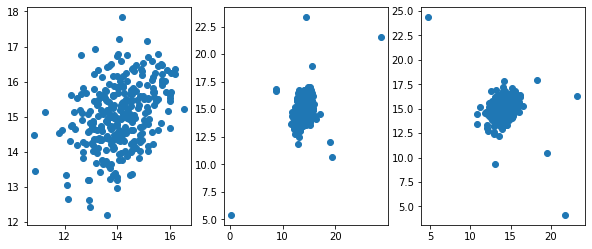

In [22]:
plt.figure(figsize=(10,4))

plt.subplot(1, 3, 1)
plt.scatter(Xtrain[:,0], Xtrain[:,1])

plt.subplot(1, 3, 2)
plt.scatter(Xval[:,0], Xval[:,1])

plt.subplot(1, 3, 3)
plt.scatter(Xtest[:,0], Xtest[:,1])


### Plot Data

Plot the histograms of each feature and get figure simular to Fig.2. 


<img src="images/im2.png" style="width:300px;height:250px;">
<caption><center> **Fig. 1** : **Data distribution** </center></caption>

In [ ]:
plt.subplot(1, 2, 1)
plt.hist(?, ?)
plt.hist(?, ?)

### Gaussian Distribution

To perform anomaly detection, you will first need to fit a model only to the normal data.

Given a training set {x(1), …, x(m)} (where x(i) ∈ R^n, here n = 2), you want to estimate the Gaussian distribution for each of the features. For each feature (i = 1 . . . n), you need to find parameters mean and variance(mu, sigma²). For doing that let’s write down the function that calculates the mean and variance of matrix Xtrain.

The Gaussian distribution is given by:  $p(x;\mu,\sigma^2) = \frac{1}{\sqrt{2\pi\sigma^2}}e^{\frac{(x-\mu)^2}{2\sigma^2}}$

mean:  $\mu_i = \frac{1}{m}\sum^m_{j=1}x^{(j)}$

variance:  $\sigma^2_i = \frac{1}{m}\sum^m_{j=1}(x^{(j)} - \mu_j)^2$

In [31]:
def estimateGaussian(X):
    """
     This function estimates the parameters of a Gaussian distribution using the data in X
    """
    m=X.shape[0]  #number of examples in X
    
    #compute mean 
    mu = sum(X)/m
     
    # compute variance =sigma^2
    sigma2 = 1/m * np.sum((X - mu)**2,axis=0)
    
    return mu,sigma2

In [32]:
# Estimate parameters (mean and variance) for the Gaussian model of the normal data (Xtrain)
# ANSWER:    mu =  [14.06411334 15.02441479] ; sigma2 = [0.93434723 0.8506542 ]

mu, sigma2 = estimateGaussian(Xtrain)
print(mu)
print(sigma2)


[14.06411334 15.02441479]
[0.93434723 0.8506542 ]


### Multivariate Gaussian Distribution

Inside *multivariateGaussian*, $\sigma^2$ vector is converted into the covariance matrix  $\Sigma$.  Assuming the features are independent, each element of vector $\sigma^2$ will be on the diagonal of matrix $\Sigma$ and the rest of the elements are zero. 
Then the formula for the multivariate distribution to get the probability vector is applied.

$p(x;\mu,\Sigma) = \frac{1}{(2\pi)^{n/2}|\Sigma|^{1/2}} exp(-\frac{1}{2}(x-\mu)^T\Sigma^{-1}(x-\mu))$

In [33]:
#Complete the function
def multivariateGaussian(X, mu, sigma2):
    """
    Computes the probability density function of the multivariate Gaussian distribution.
    """
    n= X.shape[0] #number of features 
    sigma_diag=np.diag(sigma2)  #Diagonal matrix (features are independent !!!!)
    X = X - mu.T
    p = 1/((2*np.pi)**(n/2)*(np.linalg.det(sigma_diag)**0.5))* np.exp(-0.5* np.sum(X @ np.linalg.pinv(sigma_diag) * X,axis=1))
    return p

### Select the threshold $\epsilon$  that will flag an example as anomaly

F1 score is used to determine the best parameters i.e best epsilon and best F1 instead of accuracy as the dataset is highly unbalanced. F1 score takes into consideration precision and recall.

Precision = true positive/(true positive + false positive)

Recall = true positive /(true positive + false negative)

F1=2(Recall * Precision) / (Recall + Precision)

Best parameters are the ones in which the F1 score value is maximum.

Predict anomaly if pval<epsilon that gives a vector of binary values in the variable predictions.

Note: We need a try-except block because there can be cases where we divide by zero to calculate precision and recall.

In [42]:
#Complete the function
def selectThreshold(yval, pval):
    """
    Find the best threshold (epsilon) to use for selecting outliers
    """
    best_epi = 0
    best_F1 = 0
    
    #range of threshold values to decide the best one. 
    stepsize = (max(pval) -min(pval))/1000
    epi_range = np.arange(pval.min(),pval.max(),stepsize)
    for epi in epi_range:
        print(epi)
        predictions = (pval<epi)[:,np.newaxis]
        
        #compute true positive (TP)
        tp = sum([yval == epi])
        
        #compute false positive (FP)
        fp = sum([yval != epi])
        
        #compute false negative 
        fn = sum([yval == 1])   
        
        try:
        # compute precision, recall and F1
            prec = ?
            
            #compute recall and F1
            rec = ?
            #compute  F1
            F1 = ? 
        
            if F1 > best_F1:
                best_F1 =F1
                best_epi = epi
            
        except ZeroDivisionError:
                print('Warning dividing by zero!!')  
        
    return best_epi, best_F1

In [43]:
#Apply multivariateGaussian to compute the probability of the examples in Xval. 
pval = multivariateGaussian(Xval, mu, sigma2)

#Apply selectThreshold to compute the best epsilon and best F1 with the validation data
epsilon, F1 = selectThreshold(yval, pval)

print("Best epsilon found using cross-validation:",epsilon)  #ANSWER: 0.00018
print("Best F1 on Cross Validation Set:",F1)  #ANSWER: 0.8235


7.292363129208684e-191


NameError: name 'F1' is not defined

We need to return the indices of the outliers to identify the faulty servers. This gives us a vector with binary entries where 1 means anomaly and 0 means normal.

In [ ]:
def findIndices(binVec):
    l = []
    for i in range(len(binVec)):
        if binVec[i] == 1:
            l.append(i)
    return l

In [ ]:
#Apply multivariateGaussian to detect abnormal examples (outliers) 
p = multivariateGaussian(Xtest, mu, sigma2)

outl = (p < epsilon)
listOfOutliers=findIndices(outl)
count_outliers = len(listOfOutliers)
print('\n\nNumber of outliers (Xtest):', count_outliers)  #ANSWER: 6 
print('\n',listOfOutliers)


### Visualize the anomalies

In [ ]:
plt.figure(figsize=(10,4))
plt.subplot(1, 2, 1)
plt.scatter(Xtest[:, 0], Xtest[:, 1], marker = "x")
plt.xlabel('Latency(ms)')
plt.ylabel('Throughput(mb/s)')
plt.scatter(Xtest[listOfOutliers,0], Xtest[listOfOutliers, 1], facecolors = 'none', edgecolors = 'r')
plt.xlim(-1,30)
plt.ylim(-1,30)
plt.show()